# Development notebook

Useful links written by the author:  
[Lay person's clarification on paper's results and conclusions.](https://www.linkedin.com/pulse/where-dog-laymans-version-my-mbe-paper-xuhua-xia/)  
[Paper to cite for DAMBE7](https://academic.oup.com/mbe/article/35/6/1550/4970565)  
[DAMBE website](http://dambe.bio.uottawa.ca/DAMBE/dambe.aspx)  

In [52]:
import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import numpy as np

from random import choices
from collections import Counter

import time

import matplotlib.pyplot as plt

In [35]:
covid19Ref = SeqIO.read("covid19ref.gb", "genbank")
covid19Ref

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA', IUPACAmbiguousDNA()), id='NC_045512.2', name='NC_045512', description='Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome', dbxrefs=['BioProject:PRJNA485481'])

# Count every possible pair in genome
We are interested in how possible pairs differ from the expected value. In a random model of genome formation we would expect the probability for each base being one of the four bases in our sample space {A,T,C,G} would be 1/4. We can explore this with a very simple model and a simple simulation.  

## Benchmarking different search methods
For covid19ref.gb the DAMBE single base frequencies are: A: 8954 T: 9594 C: 5492 G: 5863  
The pairs are: 'AT': 2308, 'TT': 3215, 'TA': 2377, 'AA': 2880, 'AG': 1742, 'GG': 1093, 'GT': 1990, 'AC': 2023, 'CC': 888, 'CT': 2081, 'TC': 1413, 'CA': 2084, 'CG': 439, 'GA': 1612, 'TG': 2589, 'GC': 1168

In [60]:
start = time.time()
base_count(covid19Ref.seq, bases)
print(time.time()-start)

0.0009965896606445312


## Multinomial model of random DNA sequences
The simplest model for a DNA sequence is that a given position in a sequence can have one of four outcomes {A,T,C,G}, each of which we will call a `base`. Each with a probability of 0.25. Each position is choosen independently of the others in the string. We define the length of the string as being *n* trials long while each trial will have k = 4 outcomes of X = {A,T,C,G} where p(A) = p(T) = p(C) = p(G) = 0.25 and sum together to 1. From this we can pull useful descriptive statistics:  
1. Expected value (the number we expect for this many trials) for each base will be E(x) = n\*p(x) where x is one of {A,T,C,G}
2. Variance for each `base` is Var(x) = n\*p(x)\*(1-p(x))

In [36]:
#model parameters 
n = len(covid19Ref) #length of covid19 ref genome is our number of trials
p = 0.25 #no need to define for each base as they are all the same
print('model parameters are n = %i p = %.2f'%(n,p))

#expected value of outcome
print('expected value for each base is: %.1f'%(n*p))

#variance is...
print('variance is: %.1f'%(n*p*(1-p)))

model parameters are n = 29903 p = 0.25
expected value for each base is: 7475.8
variance is: 5606.8


## Simulation of random sequence
Since this is a programming environment. It is also trivial to do a simulation of this random model where the only assumption is n = len(covid19 reference genome).

In [37]:
def generate_random_sequence(k, weights):
    '''
    Generates a random sequence using random.choices()
    Weights is a list of weightings for each choice. If you assume sum(weights) = 1 
    you can then state that these weights are probabilities for each choice.
    weights list should be in order: ['A','T','C','G']
    '''
    random_seq_list = choices(['A','T','C','G'], weights=weights, k=k)
    random_sequence = Seq("".join(random_seq_list))
    return random_sequence
a_random_sequence = generate_random_sequence(len(covid19Ref), [0.25,0.25,0.25,0.25])
a_random_sequence

Seq('AACCGAATTTCTATGTGGCATTTTTCATGTTCGATCATAGGGCAGCGTGGCCTT...CCG')

### testing our model assumptions
We can test our multinomial model fits our expectations using our simulated `a_random_sequence`.
We can see that each base appears with the frequency we would expect would fit our model

In [38]:
def base_count(sequence, base_list):
    '''
    Returns frequencies of occurance of each 'base' in base_list for the supplied sequence.
    base_list can have bases that are actually multiple bases which is useful for examing
    'CG' pairs later.
    '''
    base_counts = {}
    for base in base_list:
        base_counts[base] = sequence.count(base)
    return base_counts
bases = ['A','T','C','G']

#cycle through results from base_count() to print formatted results
randSeqBaseCounts =  base_count(a_random_sequence, bases)

for base in randSeqBaseCounts:
    print('For base %s; count: %i proportion of all bases: %.2f'%
          (base, randSeqBaseCounts[base], randSeqBaseCounts[base]/len(covid19Ref)))

For base A; count: 7464 proportion of all bases: 0.25
For base T; count: 7446 proportion of all bases: 0.25
For base C; count: 7555 proportion of all bases: 0.25
For base G; count: 7438 proportion of all bases: 0.25


In [39]:
#making sure this sums to number of pairs in sequence
len(covid19Ref) == sum(randSeqBaseCounts.values())

True

## For multiple random sequences
And we can do the same with a whole set of randomly generated sequences. Here `n` = 100 so that this cell runs quickly. We can see the average frequency for each base remains consistent.  
Note that variance approaches our multinomial model when `n` = 1000

In [40]:
#This takes a little to run so it gets it's own cell
setOfRandomSequences = [generate_random_sequence(len(covid19Ref), [0.25,0.25,0.25,0.25]) for x in range(0,1000)]

In [41]:
#this algorithm is bespoke since it is for a list of sequences. Might turn this into a function later.
base_counts = {'A':[],'T':[],'C':[],'G':[]}
#get frequencies of each base in sequence in our set of random sequences
for sequence in setOfRandomSequences:
    for base in base_counts:
        base_counts[base].append(sequence.count(base))
#loop through each base to print formatted results
for base in base_counts:
    print('For base %s; avg count: %i variance: %.2f proportion of all bases: %.2f'%
          (base, np.mean(base_counts[base]), np.var(base_counts[base]), np.mean(base_counts[base])/len(covid19Ref)))

For base A; avg count: 7474 variance: 5987.76 proportion of all bases: 0.25
For base T; avg count: 7473 variance: 5827.84 proportion of all bases: 0.25
For base C; avg count: 7480 variance: 6083.38 proportion of all bases: 0.25
For base G; avg count: 7474 variance: 5054.26 proportion of all bases: 0.25


## Examining the base frequencies in covid-19
Covid19 will deviate significantly from this model since base composition is under strong selection pressure. Microorganisms and viruses are under a number of selective pressures that bias them towards having a higher proportion of A and T bases compared to C and G.  
This is the same result as achieved with DAMBE:  
A: 8954 T: 9594 C: 5492 G: 5863

In [42]:
#cycle through results from base_count() to print formatted results
CovidBaseCounts =  base_count(covid19Ref.seq, bases)

for base in CovidBaseCounts:
    print('For base %s; count: %i proportion of all bases: %.2f'%
          (base, CovidBaseCounts[base], CovidBaseCounts[base]/len(covid19Ref)))

For base A; count: 8954 proportion of all bases: 0.30
For base T; count: 9594 proportion of all bases: 0.32
For base C; count: 5492 proportion of all bases: 0.18
For base G; count: 5863 proportion of all bases: 0.20


## Adjusting the simulation based on covid-19 base frequencies
We can adjust our weights based on the results above using the proportions given.

In [43]:
covid19_weights = [0.30,0.32,0.18,0.20]

#generate 1000 sequences with the same weightings as covid19 bases
setOfRandomSeqs_covidweights = [generate_random_sequence(k=len(covid19Ref), weights= covid19_weights) for x in range(0,1000)]

randomSeq_base_counts_covidweights = {'A':[],'T':[],'C':[],'G':[]}

#output some stats
for sequence in setOfRandomSeqs_covidweights:
    for base in randomSeq_base_counts_covidweights:
        base_counts[base].append(sequence.count(base))
#loop through each base to print formatted results
for base in randomSeq_base_counts_covidweights:
    print('For base %s; avg count: %i variance: %.2f proportion of all bases: %.2f'%
          (base, np.mean(base_counts[base]), np.var(base_counts[base]), np.mean(base_counts[base])/len(covid19Ref)))

For base A; avg count: 8221 variance: 564873.48 proportion of all bases: 0.27
For base T; avg count: 8521 variance: 1105208.23 proportion of all bases: 0.28
For base C; avg count: 6432 variance: 1103565.66 proportion of all bases: 0.22
For base G; avg count: 6726 variance: 564345.12 proportion of all bases: 0.22


# Counts of pairs of bases
We can now extend our analysis to pairs of bases. We are ultimately interested in measuring the proportion of sequences that are *CpG*. *CpG* is short notation for "Cytosine-phosphate-Guanine" where "phosphate" refers to the phosphate group that is the linker molecule between any two bases in a nucleotide sequence. In other words *CpG* = 'CG'.

In [44]:
base_doubles = ['AT', 'TT', 'TA', 'AA', 'AG', 'GG', 'GT', 'AC', 'CC', 'CT', 'TC', 'CA', 'CG', 'GA', 'TG', 'GC'] #can't call them base_pairs since that refers to double stranded nucleotide pairs which this is not

## Base-doublets in Covid-19 reference genome

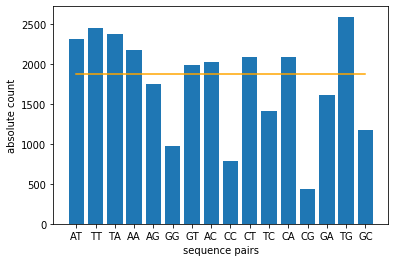

In [45]:
covid_base_doubles = base_count(covid19Ref.seq, base_doubles)

#plot this
x = list(covid_base_doubles.keys())
heights = list(covid_base_doubles.values())
plt.bar(x,heights)
plt.xlabel('sequence pairs')
plt.ylabel('absolute count')
#the E(x) for each doublet of bases is E(single_base)/4 since each doublet event is not independent of all other doublet events.
plt.plot(x,[7475/4 for x in range(0,len(x))], 'orange')
plt.show()

This method will find less doublets than DAMBE or the method using `Counter()` below

In [46]:
covid_base_doubles

{'AT': 2308,
 'TT': 2454,
 'TA': 2377,
 'AA': 2169,
 'AG': 1742,
 'GG': 973,
 'GT': 1990,
 'AC': 2023,
 'CC': 784,
 'CT': 2081,
 'TC': 1413,
 'CA': 2084,
 'CG': 439,
 'GA': 1612,
 'TG': 2589,
 'GC': 1168}

In [47]:
sum(covid_base_doubles.values())/len(covid19Ref)

0.9432498411530615

This cell will count every possible pair in the genome and output the results as a dict. Produces the same result as `DAMBE`.

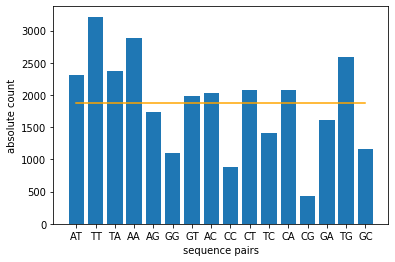

In [48]:
sequence_pairs = []

for i in range(0,len(covid19Ref.seq)-1):
    sequence_pairs.append(str(covid19Ref.seq[i:i+2]))

temp_seq_dict = Counter(sequence_pairs)
#counter returns a seq object as the key in this list so need to replace with string
seqpair_freq = {}
for key in temp_seq_dict:
    new_key = str(key)
    seqpair_freq[new_key] = temp_seq_dict[key]

#plot this
x = list(seqpair_freq.keys())
heights = list(seqpair_freq.values())
plt.bar(x,heights)
plt.xlabel('sequence pairs')
plt.ylabel('absolute count')
plt.plot(x,[7475/4 for x in range(0,len(x))], 'orange')
plt.show()

In [49]:
sum(seqpair_freq.values())/len(covid19Ref)

0.999966558539277

In [50]:
print(seqpair_freq)

{'AT': 2308, 'TT': 3215, 'TA': 2377, 'AA': 2880, 'AG': 1742, 'GG': 1093, 'GT': 1990, 'AC': 2023, 'CC': 888, 'CT': 2081, 'TC': 1413, 'CA': 2084, 'CG': 439, 'GA': 1612, 'TG': 2589, 'GC': 1168}
